In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.feature_selection import RFE

%matplotlib inline

In [2]:
fa = pd.read_csv('allFA.csv')
per = pd.read_csv('allPer 36.csv')
adv = pd.read_csv('allAdvanced.csv')

In [3]:
per = per[per.Rk != 'Rk']
adv = adv[adv.Rk != 'Rk']

fa.rename(columns={fa.columns.values[0]:'Player'}, inplace=True)
fa.rename(columns={'2018 CAP HIT':'Cap Hit'}, inplace=True)

df = fa.merge(per, on=['Player', 'Season']).merge(adv, on=['Player', 'Season'])
cols = [c for c in df.columns if c.lower()[-2:] != '_y']
df=df[cols]
cols = []
for c in df.columns:
    if c.lower()[-2:] == '_x':
        cols.append(c[:-2])
    else:
        cols.append(c)

df.columns = cols
df.replace('0-', 0, inplace=True)
df.replace('-', 0, inplace=True)
# df = df[df.To != 'TBD']
df.iloc[:,7:10] = df[df.columns[7:10]].replace('[\$,]', '', regex=True).astype(float)
df = df.apply(pd.to_numeric, errors='ignore')
df.drop(columns=['OWS','DWS','WS','WS/48','PER','PercCap','TYPE'], inplace=True)
df.rename(columns={'AVG. SALARY':'AvgSalary'}, inplace=True)
df['AvgSalary'] = df.AvgSalary/1000000
df["Cap Hit/Cap"] = df['Cap Hit']/df['Cap']


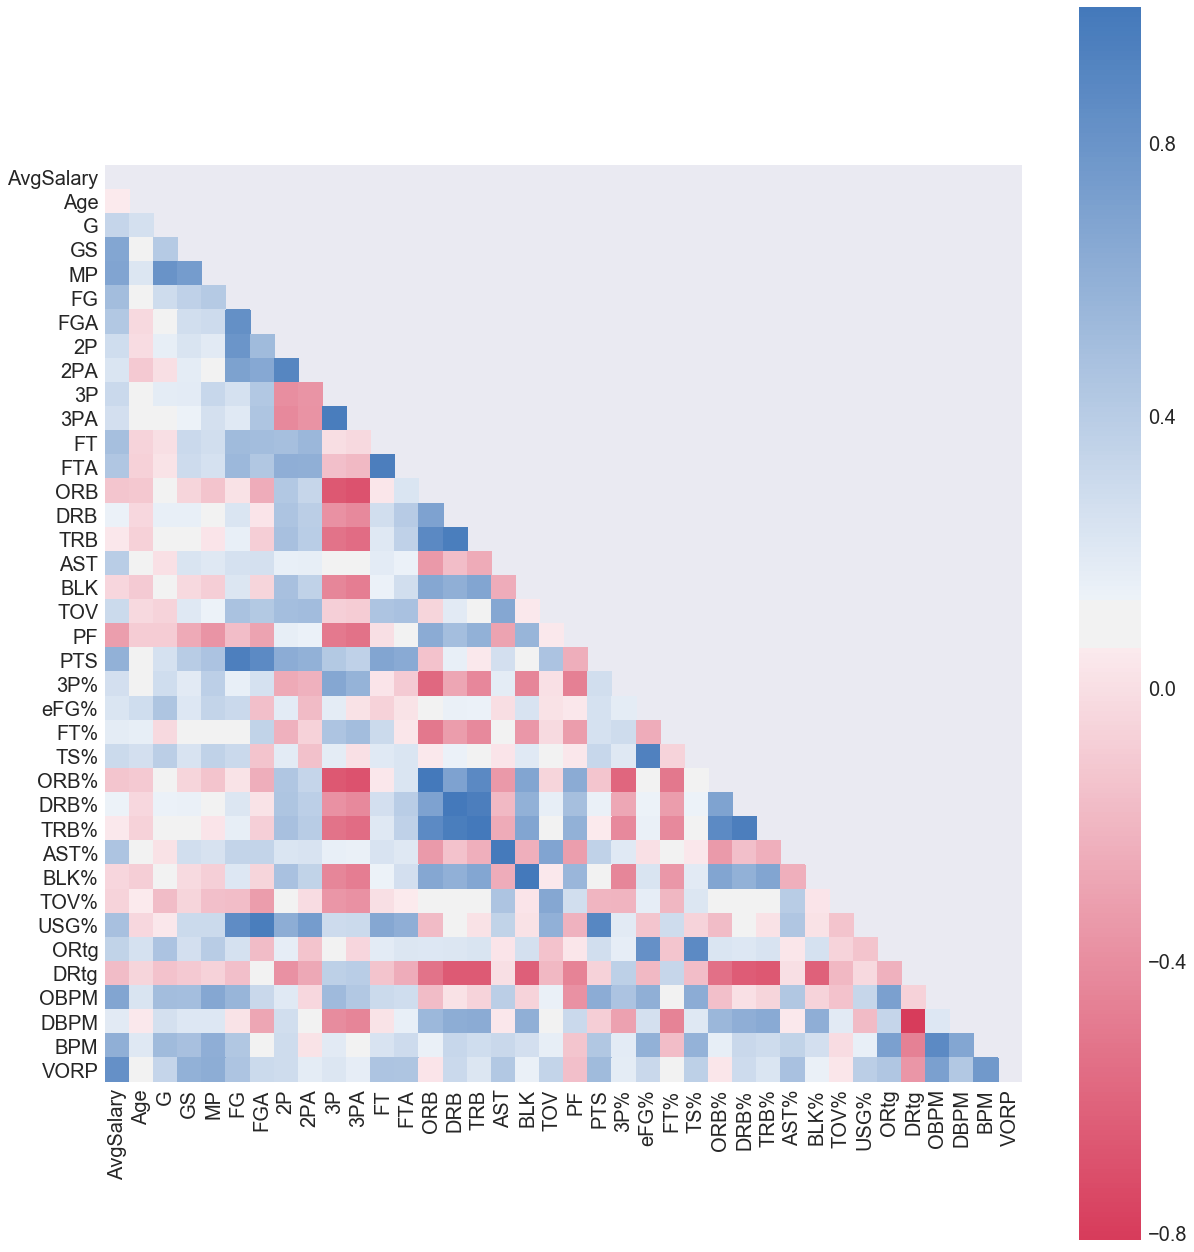

In [5]:
from pandas.tools.plotting import table
fig, ax = plt.subplots(figsize=(18,18)) 
sns.set(font_scale=1.4)
traindf = df[df.TO != 'TBD']
mydf = traindf.drop(columns=['DOLLARS','YRS','Cap Hit/Cap','Cap Hit','Cap','Rk','AGE','3PAr','FTr','2P%','FG%','STL','STL%'])
cor = mydf.corr()
# cor.drop(labels=['DOLLARS','YRS','Cap Hit/Cap','Cap Hit', 'AvgSalary'], inplace=True)
cmap=sns.diverging_palette(5, 250, as_cmap=True)
# sns.heatmap(cor.round(2), cmap=cmap, ax=ax)
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True
sns.set(font_scale=2)
with sns.axes_style("white"):
    p2 = sns.heatmap(cor, mask=mask, square=True, cmap=cmap)

plt.tight_layout()
plt.savefig('corMatrix.png')
# cor.style.background_gradient(cmap, axis=0)


# ax = plt.subplot(111, frame_on=False) # no visible frame
# ax.xaxis.set_visible(False)  # hide the x axis
# ax.yaxis.set_visible(False)  # hide the y axis

# table(ax, dftab )  # where df is your data frame

# plt.savefig('mytable.png')

In [7]:

from sklearn.linear_model import LinearRegression
features = ['VORP','GS', 'PF']
X = traindf[features]
y = traindf['AvgSalary']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

regr = LinearRegression()

regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

resid = (y_test - y_pred)
rss = np.sum(resid**2)
se = np.sqrt(rss/(len(resid) - (len(features)-1)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
salMean = y.mean()
mae = mean_absolute_error(y_test,y_pred)
mape = mae/salMean
percError = se/salMean
print (features)
print('Coefficients: \n', regr.coef_)
print("RSS: %.2f" % rss)
print("MSE: %.2f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.2f" % rmse)
print("MAE: %.2f" % mae)
print("Mean Salary: %.2f" % salMean)
print("SE: %.2f" % se)
print("MAPE: %.3f " % mape )
print("Percent Error: %.3f " % percError )
# Explained variance score: 1 is perfect prediction
print('Variance score: %f' % regr.score(X_train,y_train))


['VORP', 'GS', 'PF']
Coefficients: 
 [ 3.82648915  0.07797552 -1.23912406]
RSS: 765.48
MSE: 16.29
RMSE: 4.04
MAE: 3.10
Mean Salary: 8.21
SE: 4.12
MAPE: 0.378 
Percent Error: 0.502 
Variance score: 0.743736


In [8]:
X_train.corr()

,VORP,GS,PF
VORP,1.000000,0.598514,-0.160600
GS,0.598514,1.000000,-0.240619
PF,-0.160600,-0.240619,1.000000


In [9]:
from sklearn.linear_model import RidgeCV
traindf.dropna(axis=1, inplace=True)
myfeats = ['Age','G', 'GS', 'MP', 'FG', 'FGA', '2P', '2PA', '3P', '3PA', 'FT',
       'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'FG%', '2P%', 'eFG%', 'TS%', 'FTr',
       'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
       'ORtg', 'DRtg', 'OBPM', 'DBPM', 'BPM', 'VORP']
X = traindf[myfeats]
y = traindf['AvgSalary']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RidgeCV()
clf.fit(X, y)

# Make predictions using the testing set
y_pred = clf.predict(X_test)

resid = (y_test - y_pred)
rss = np.sum(resid**2)
se = np.sqrt(rss/(len(resid) - (len(features)-1)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
salMean = y.mean()
mae = mean_absolute_error(y_test,y_pred)
mape = mae/salMean
percError = se/salMean


print("RSS: %.2f" % rss)
print("MSE: %.2f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.2f" % rmse)
print("MAE: %.2f" % mae)
print("Mean Salary: %.2f" % salMean)
print("SE: %.2f" % se)
print("MAPE: %.3f " % mape )
print("Percent Error: %.3f " % percError )
# Explained variance score: 1 is perfect prediction
print('Variance score: %f' % clf.score(X_train,y_train))

RSS: 587.06
MSE: 12.49
RMSE: 3.53
MAE: 2.58
Mean Salary: 8.21
SE: 3.61
MAPE: 0.314 
Percent Error: 0.440 
Variance score: 0.808829


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
bldf = df[df.Player == 'LeBron James']
blX = bldf[myfeats]
print(blX)
brookLopezPred = clf.predict(blX)
print(brookLopezPred)


     Age   G  GS    MP    FG   FGA   2P   2PA   3P  3PA  ...   STL%  BLK%  \
100   33  82  82  3026  10.2  18.8  8.4  14.0  1.8  4.8  ...    1.9   2.0   

     TOV%  USG%  ORtg  DRtg  OBPM  DBPM  BPM  VORP  
100  16.1  31.6   118   109   7.6   2.0  9.6   8.9  

[1 rows x 40 columns]
[41.72558312]


In [13]:
pred2 = clf.predict(X)
resid2 = (y-pred2)

ilist = resid2.index.tolist()


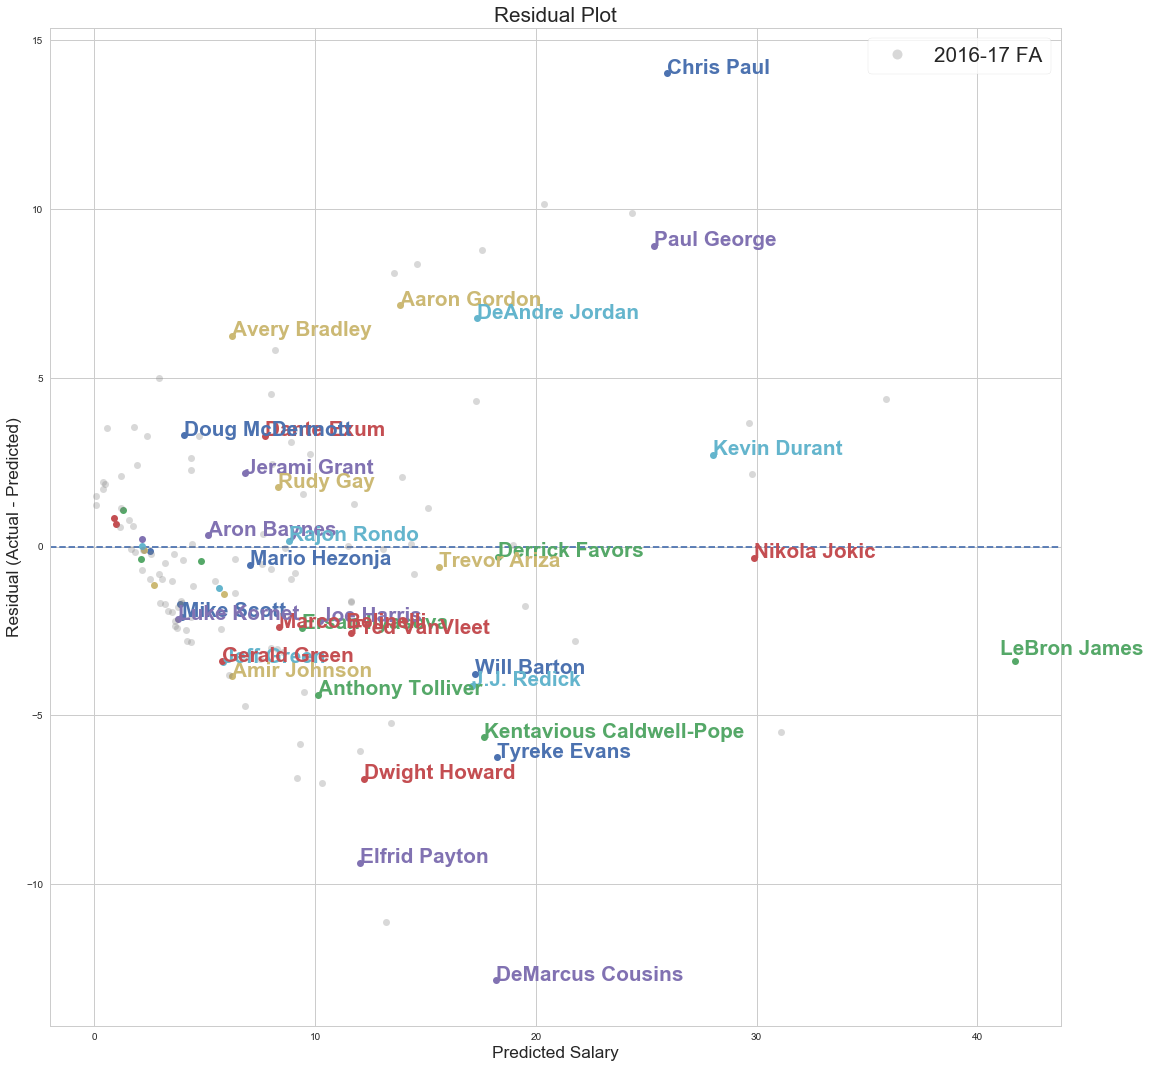

In [32]:
from matplotlib.lines import Line2D
sns.set(font_scale=1)
customLegend = [Line2D([0], [0], marker='o', color='w', label='2016-17 FA',
                          markerfacecolor='gray', alpha=0.3, markersize=10)]
curFA = traindf[traindf.Season == '2017-18']
sns.set_style("whitegrid")

sns.set_palette('deep', curFA.shape[0] )
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

ax.axhline(linestyle='dashed')
i = 0
for pt in range(0,resid2.shape[0]):
    curdf = traindf.iloc[pt,:]
    if pred2[pt] > 0:
        if curdf['Season'] == '2017-18':
            p = ax.plot(pred2[pt], resid2.iloc[pt],'o')
            if (np.abs(resid2.iloc[pt]) > 2) | (y.iloc[pt] > 5):
                if curdf.Player == "LeBron James":
                    ax.annotate(traindf.Player.iloc[pt], xy=(pred2[pt] - .7, resid2.iloc[pt]+ .2),
                                color=p[0].get_color(), fontsize='xx-large', fontweight="bold")
                else:
                    ax.annotate(traindf.Player.iloc[pt], xy=(pred2[pt], resid2.iloc[pt]),
                                color=p[0].get_color(), fontsize='xx-large', fontweight="bold")
            i = i+1
        else:
            ax.plot(pred2[pt], resid2.iloc[pt],'o', color='gray', alpha=0.3, label='2016-17 FA')
ax.legend(handles = customLegend, frameon=True, fancybox=True, fontsize='xx-large')
ax.set_xlabel('Predicted Salary', fontsize='x-large')
ax.set_ylabel('Residual (Actual - Predicted)', fontsize='x-large')
ax.set_title('Residual Plot', fontsize='xx-large')
plt.tight_layout()
plt.savefig('residPlot.png')
